In [ ]:
pip install pdfplumber python-Levenshtein jiwer


  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/5.6 MB ? eta -:--:--
   -------------------- ------------------- 2.9/5.6 MB 15.2 MB/s eta 0:00:01
   ---------------------------------------  5.5/5.6 MB 15.2 MB/s eta 0:00:01
   ---------------------------------------- 5.6/5.6 MB 10.7 MB/s eta 0:00:00
Using cached click-8.1.8-py3-none-any.whl (98 kB)
   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   -------------------------------------- - 2.9/3.0 MB 15.2 MB/s eta 0:00:01
   ---------------------------------------- 3.0/3.0 MB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 8.7 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7


In [ ]:
import pdfplumber
from jiwer import wer, cer
import pandas as pd
import numpy as np

# --- Chargement de texte ---

def extract_lines_from_pdf(pdf_path):
    lines = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                lines.extend([line.strip() for line in page_text.splitlines() if line.strip()])
    return lines

def read_manual_lines(txt_path):
    with open(txt_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.read().splitlines() if line.strip()]

def extract_full_text(pdf_path):
    full_text = ''
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:
                full_text += text.replace('\n', ' ') + ' '
    return full_text.strip()

def read_manual_full_text(txt_path):
    with open(txt_path, "r", encoding="utf-8") as f:
        return f.read().replace('\n', ' ').strip()

def group_lines(lines, block_size=3):
    return [' '.join(lines[i:i + block_size]) for i in range(0, len(lines) - block_size + 1)]

# --- Méthodes de comparaison ---

def compare_exact_line_matching(ocr_lines, manual_lines):
    wer_list, cer_list = [], []
    max_len = max(len(ocr_lines), len(manual_lines))
    for i in range(max_len):
        ref = manual_lines[i] if i < len(manual_lines) else ""
        hyp = ocr_lines[i] if i < len(ocr_lines) else ""
        if not ref.strip() or not hyp.strip():
            wer_list.append(np.nan)
            cer_list.append(np.nan)
        else:
            wer_list.append(wer(ref, hyp))
            cer_list.append(cer(ref, hyp))
    return wer_list, cer_list

def compare_best_line_match(ocr_lines, manual_lines):
    used = set()
    wer_list, cer_list = [], []
    for hyp in ocr_lines:
        if not hyp.strip():
            wer_list.append(np.nan)
            cer_list.append(np.nan)
            continue

        best_score, best_cer = float('inf'), float('inf')
        best_index = None
        for i, ref in enumerate(manual_lines):
            if i in used or not ref.strip():
                continue
            score = wer(ref, hyp)
            if score < best_score:
                best_score = score
                best_cer = cer(ref, hyp)
                best_index = i

        if best_index is not None:
            used.add(best_index)
            wer_list.append(best_score)
            cer_list.append(best_cer)
        else:
            wer_list.append(np.nan)
            cer_list.append(np.nan)
    return wer_list, cer_list

def compare_best_block_match(ocr_lines, manual_lines, block_size=3):
    ocr_blocks = group_lines(ocr_lines, block_size)
    manual_blocks = group_lines(manual_lines, block_size)
    used = set()
    wer_list, cer_list = [], []
    for hyp in ocr_blocks:
        if not hyp.strip():
            wer_list.append(np.nan)
            cer_list.append(np.nan)
            continue

        best_score, best_cer = float('inf'), float('inf')
        best_index = None
        for i, ref in enumerate(manual_blocks):
            if i in used or not ref.strip():
                continue
            score = wer(ref, hyp)
            if score < best_score:
                best_score = score
                best_cer = cer(ref, hyp)
                best_index = i

        if best_index is not None:
            used.add(best_index)
            wer_list.append(best_score)
            cer_list.append(best_cer)
        else:
            wer_list.append(np.nan)
            cer_list.append(np.nan)
    return wer_list, cer_list

def compare_global_text(pdf_path, txt_path):
    ref = read_manual_full_text(txt_path)
    hyp = extract_full_text(pdf_path)
    if not ref.strip() or not hyp.strip():
        return [np.nan], [np.nan]
    return [wer(ref, hyp)], [cer(ref, hyp)]

# --- Fusion dans un DataFrame ---

def compare_all_methods(pdf_path, txt_path):
    ocr_lines = extract_lines_from_pdf(pdf_path)
    manual_lines = read_manual_lines(txt_path)

    wer1, cer1 = compare_exact_line_matching(ocr_lines, manual_lines)
    wer2, cer2 = compare_best_line_match(ocr_lines, manual_lines)
    wer3, cer3 = compare_best_block_match(ocr_lines, manual_lines, block_size=3)
    wer4, cer4 = compare_global_text(pdf_path, txt_path)

    max_len = max(len(wer1), len(wer2), len(wer3))
    df = pd.DataFrame({
        "Ligne": list(range(1, max_len + 1)),
        "WER_M1_LigneExacte": wer1 + [np.nan] * (max_len - len(wer1)),
        "CER_M1_LigneExacte": cer1 + [np.nan] * (max_len - len(cer1)),
        "WER_M2_MatchLigne": wer2 + [np.nan] * (max_len - len(wer2)),
        "CER_M2_MatchLigne": cer2 + [np.nan] * (max_len - len(cer2)),
        "WER_M3_MatchBloc": wer3 + [np.nan] * (max_len - len(wer3)),
        "CER_M3_MatchBloc": cer3 + [np.nan] * (max_len - len(cer3)),
    })

    df.loc[0, "WER_M4_Global"] = wer4[0]
    df.loc[0, "CER_M4_Global"] = cer4[0]

    return df

# --- Utilisation ---

pdf_file = r"C:\2. Stage\pdf lisible\16b_16.pdf"
txt_file = r"C:\2. Stage\pdf lisible\16b_16.txt"

df_results = compare_all_methods(pdf_file, txt_file)

print(df_results.head(10))

# Export facultatif :
# df_results.to_csv("resultats_comparaison_ocr.csv", index=False)


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

   Ligne  WER_M1_LigneExacte  CER_M1_LigneExacte  WER_M2_MatchLigne  \
0      1            0.625000            0.325581           0.625000   
1      2            0.500000            0.136364           0.500000   
2      3            0.400000            0.111111           0.400000   
3      4            6.000000            7.000000           0.600000   
4      5            1.000000            0.969697           0.000000   
5      6            1.200000            0.850000           0.166667   
6      7            1.000000            0.846154           0.333333   
7      8            1.500000            0.833333           0.444444   
8      9            1.000000            0.826087           0.333333   
9     10            1.166667            0.897436           0.500000   

   CER_M2_MatchLigne  WER_M3_MatchBloc  CER_M3_MatchBloc  WER_M4_Global  \
0           0.325581          0.523810          0.198276       0.367911   
1           0.136364          0.857143          0.564103            

In [5]:
import matplotlib.pyplot as plt

def plot_wer_cer_comparison(df):
    lignes = df["Ligne"]

    # Tracer WER
    plt.figure(figsize=(12, 6))
    plt.plot(lignes, df["WER_M1_LigneExacte"], label="M1 : Ligne exacte", marker='o')
    plt.plot(lignes, df["WER_M2_MatchLigne"], label="M2 : Meilleure ligne", marker='s')
    plt.plot(lignes, df["WER_M3_MatchBloc"], label="M3 : Meilleur bloc", marker='^')
    plt.title("Comparaison WER par méthode")
    plt.xlabel("Ligne")
    plt.ylabel("WER")
    plt.ylim(0, 2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Tracer CER
    plt.figure(figsize=(12, 6))
    plt.plot(lignes, df["CER_M1_LigneExacte"], label="M1 : Ligne exacte", marker='o')
    plt.plot(lignes, df["CER_M2_MatchLigne"], label="M2 : Meilleure ligne", marker='s')
    plt.plot(lignes, df["CER_M3_MatchBloc"], label="M3 : Meilleur bloc", marker='^')
    plt.title("Comparaison CER par méthode")
    plt.xlabel("Ligne")
    plt.ylabel("CER")
    plt.ylim(0, 2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

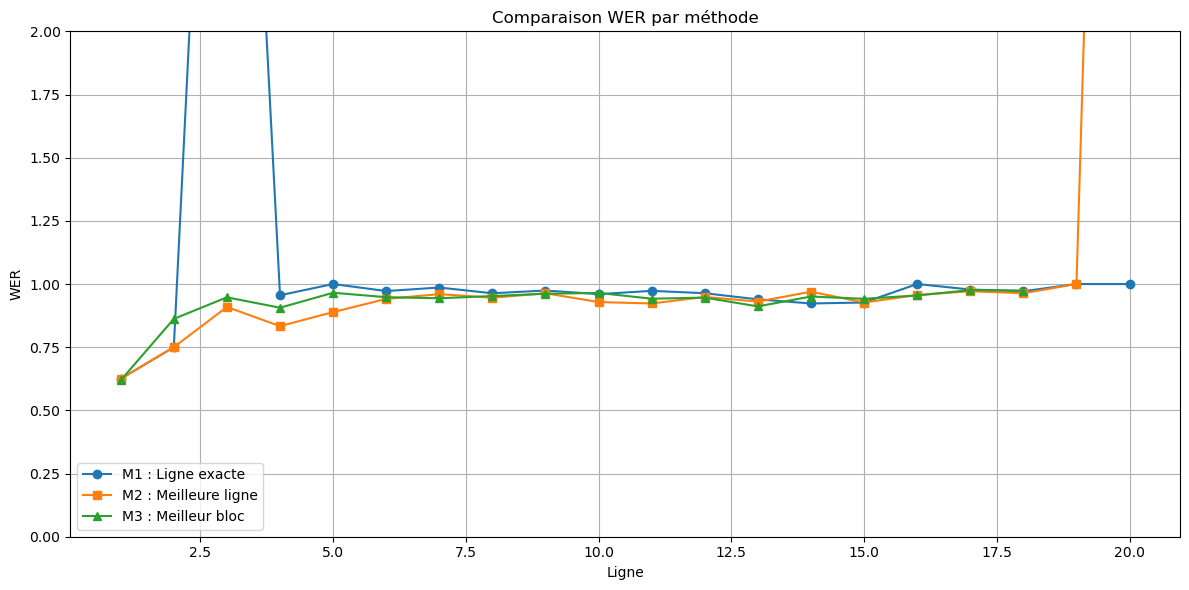

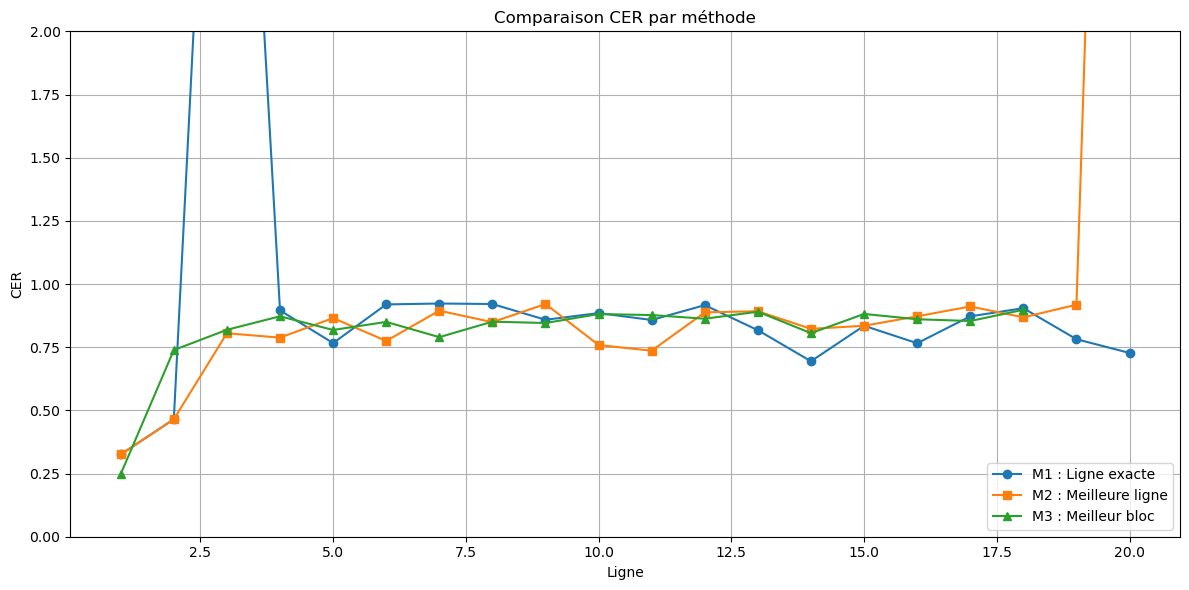

In [3]:
plot_wer_cer_comparison(df_results)


In [6]:
import os
import glob

# --- Dossiers contenant les fichiers ---
ocr_folder = r"C:\2. Stage\pdf lisible"
txt_folder = r"C:\2. Stage\pdf lisible"

# --- Identifier toutes les bases de noms communes ---
pdf_files = glob.glob(os.path.join(ocr_folder, "16b_*.pdf"))
base_names = [os.path.splitext(os.path.basename(f))[0] for f in pdf_files]

# --- Boucle sur chaque paire ---
for base in base_names:
    pdf_path = os.path.join(ocr_folder, base + ".pdf")
    txt_path = os.path.join(txt_folder, base + ".txt")

    if not os.path.exists(txt_path):
        print(f"[⚠️] Transcription manuelle manquante pour : {base}")
        continue

    print(f"\n🔍 Analyse du fichier : {base}")
    df = compare_all_methods(pdf_path, txt_path)

    # Export CSV (optionnel)
    df.to_csv(f"comparaison_{base}.csv", index=False)

    # Optionnel : afficher les scores globaux
    print(f"WER global : {df.loc[0, 'WER_M4_Global']:.2%}")
    print(f"CER global : {df.loc[0, 'CER_M4_Global']:.2%}")


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox



🔍 Analyse du fichier : 16b_108


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


WER global : 122.64%
CER global : 82.02%

🔍 Analyse du fichier : 16b_128


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

WER global : 68.44%
CER global : 40.07%

🔍 Analyse du fichier : 16b_16


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

WER global : 36.79%
CER global : 15.65%

🔍 Analyse du fichier : 16b_233


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

WER global : 106.57%
CER global : 75.52%

🔍 Analyse du fichier : 16b_33


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

WER global : 120.52%
CER global : 80.17%
